# CIFAR10

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## DenseNet
### EDA

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
cifar10 = keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

unique, counts = np.unique(y_train, return_counts=True)
print(f"Train Labels: {dict(zip(unique, counts))}")

unique, counts = np.unique(y_test, return_counts=True)
print(f"Test Labels: {dict(zip(unique, counts))}")

Train Labels: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
Test Labels: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


In [4]:
y_train.shape

(50000, 1)

In [5]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

num_classes = len(np.unique(y_train))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Modeling

In [6]:
from keras.layers import Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Flatten, Dense, Dropout

In [7]:
# Training Parameters
batch_size = 32
epochs = 5 # 200
data_augmentation = True

# Network Parameters
num_dense_blocks = 3
use_max_pool = False

growth_rate = 12
depth = 100
num_bottleneck_layers = (depth-4)//(2*num_dense_blocks)

num_filters_bef_dense_block = 2*growth_rate
compression_factor = 0.5

input_shape = x_train.shape[1:]

In [1]:
def densenet(input_shape, num_filters_bef_dense_block, num_dense_blocks, num_bottleneck_layers, data_augmentation, compression_factor, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    # <BN-ReLU-Conv2D>
    x = BatchNormalization()(inputs)
    x = Activation('relu')(x)
    x = Conv2D(filters=num_filters_bef_dense_block,
               kernel_size=3,
               padding='same',
               kernel_initializer='he_normal'
              )(x)
    x = keras.layers.concatenate([inputs, x])
    
    # Stack of dense blocks bridged by transition layers
    for i in range(num_dense_blocks):
        
        # A dense block is a stack of bottleneck layers
        # <BN-ReLU-Conv2D> - <BN-ReLU-Conv2D> - Concat
        for j in range(num_bottleneck_layers):
            y = BatchNormalization()(x)
            y = Activation('relu')(y)
            y = Conv2D(4*growth_rate, # Limit the number of Filters (4xk)
                       kernel_size=1,
                       padding='same',
                       kernel_initializer='he_normal'
                      )(y)
            if not data_augmentation:
                y = Dropout(0.2)(y)
            y = BatchNormalization()(y) # Through Bottleneck Layer, 4xk filters are input BN Layer
            y = Activation('relu')(y)
            y = Conv2D(growth_rate,
                       kernel_size=3,
                       padding='same',
                       kernel_initializer='he_normal'
                      )(y)
            if not data_augmentation:
                y = Dropout(0.2)(y)
            x = keras.layers.concatenate([x, y])
        
        # No transition layer after the last dense block
        if i == num_dense_blocks - 1:
            continue
        
        # Transition layer compresses num of feature maps and reduces the size by 2
        num_filters_bef_dense_block += num_bottleneck_layers * growth_rate
        num_filters_bef_dense_block = int(num_filters_bef_dense_block * compression_factor) # Reduce num of feature map by 0.5 times
        y = BatchNormalization()(x)
        y = Conv2D(num_filters_bef_dense_block,
                   kernel_size=1,
                   padding='same',
                   kernel_initializer='he_normal'
                  )(y)
        if not data_augmentation:
            y = Dropout(0.2)(y)
        x = AveragePooling2D()(y) # Reduce num of filters by 0.5 times
    
    
    # add classifier on top
    # after average pooling size of feature map is 1 x 1
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    kernel_initializer='he_normal',
                    activation='softmax'
                   )(y)
    
    # instantiate and compile model
    # orig paper uses SGD but RMSprop works better for DenseNet
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
model = densenet(input_shape = input_shape,
                 num_filters_bef_dense_block = num_filters_bef_dense_block,
                 num_dense_blocks = num_dense_blocks,
                 num_bottleneck_layers = num_bottleneck_layers,
                 data_augmentation = True,
                 compression_factor = compression_factor,
                 num_classes = num_classes)
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(1e-3),
              metrics=['accuracy']
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 3)   12          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 3)    0           ['batch_normalization[0][0]']    
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 24)   672         ['activation[0][0]']         

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.84678 to fit



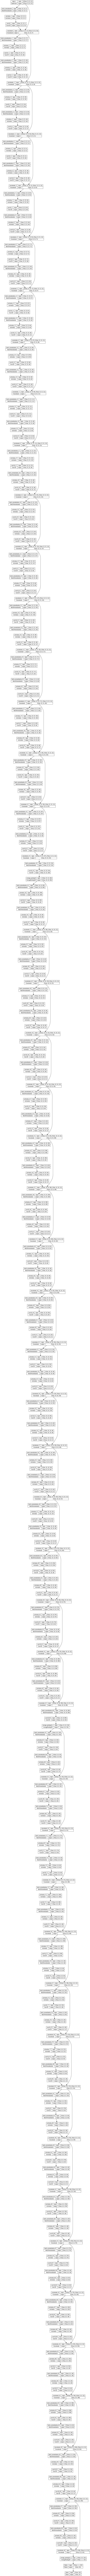

In [10]:
keras.utils.plot_model(model, to_file="cifar10-densenet.png", show_shapes=True)

In [11]:
def lr_schedule(epoch):
    # Learning Rate Schedule
    
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print(f"Learning rate: {lr}")
    return lr

In [12]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import os

In [13]:
# Prepare model saving directory
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_densenet_model.{epoch:02d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir) # 경로 상의 모든 폴더들을 다 만들어줌
filepath = os.path.join(save_dir, model_name)

In [14]:
# Prepare callbacks for model saving and for learning rate adjustment
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True
                            )
lr_scheduler = LearningRateScheduler(lr_schedule)

# 학습속도 감소 스케줄 전에 지표 개선이 정체되는 경우, 검증 손실이 patience세대 후에 개선되지 않으면 factor만큼 학습속도를 감소
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6
                              )
callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [15]:
if not data_augmentation:
    print("Not using data augmentation.")
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks
             )
else:
    print("Using real-time data augmentation.")
    #This will do preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        # Set input mean to 0 over the dataset
        featurewise_center=False,
        
        # Set each sample mean to 0
        samplewise_center=False,
        
        # Divide inputs by std of dataset
        featurewise_std_normalization=False,
        
        # Divide each input by its std
        samplewise_std_normalization=False,
        
        # Apply ZCA whitening
        zca_whitening=False,
        
        # Epsilon for ZCA whitening
        zca_epsilon=1e-06,
        
        # Randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        
        # Randomly shift images horizontally
        width_shift_range=0.1,
        
        # Randomly shift images vertically
        height_shift_range=0.1,
        
        # Set range for random shear
        shear_range=0.,
        
        # Set range for random zoom
        zoom_range=0.,
        
        # Set range for random channel shifts
        channel_shift_range=0.,
        
        # Set mode for filling points outside the input boundaries
        fill_mode='nearest',
        
        # Value used for fill_mode = "constant"
        cval=0.,
        
        # Randomly flip images
        horizontal_flip=True,
        
        # Randomly flip images
        vertical_flip=False,
        
        # Set rescaling factor (applied before any other transformation)
        rescale=None,
        
        # Set function that will be applied on each input
        preprocessing_function=None,
        
        # Image data format, either "channels_first" or "channels_last"
        data_format=None,
        
        # Fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0
    )
    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)
    
    # Fit the model on the batches generated by datagen.flow().
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
              validation_data=(x_test, y_test),
              epochs=epochs, verbose=1,
              steps_per_epoch=x_train.shape[0] // batch_size,
              callbacks=callbacks
             )
    
    # Score trained model
    scores = model.evaluate(x_test, y_test, verbose=1)
    print("Test loss:", scores[0])
    print("Test accuracy:", scores[1])

Using real-time data augmentation.
Learning rate: 0.001
Epoch 1/5
1562/1562 [==============================] - ETA: 0s - loss: 1.5175 - accuracy: 0.4547
Epoch 1: val_accuracy improved from -inf to 0.58890, saving model to /content/saved_models/cifar10_densenet_model.01.h5
1562/1562 [==============================] - 222s 128ms/step - loss: 1.5175 - accuracy: 0.4547 - val_loss: 1.1929 - val_accuracy: 0.5889 - lr: 0.0010
Learning rate: 0.001
Epoch 2/5
1562/1562 [==============================] - ETA: 0s - loss: 1.0025 - accuracy: 0.6463
Epoch 2: val_accuracy did not improve from 0.58890
1562/1562 [==============================] - 197s 126ms/step - loss: 1.0025 - accuracy: 0.6463 - val_loss: 1.3257 - val_accuracy: 0.5872 - lr: 0.0010
Learning rate: 0.001
Epoch 3/5
1562/1562 [==============================] - ETA: 0s - loss: 0.7622 - accuracy: 0.7334
Epoch 3: val_accuracy improved from 0.58890 to 0.74090, saving model to /content/saved_models/cifar10_densenet_model.03.h5
1562/1562 [======